## Command 실습 - 고객 서비스 티켓 워크플로우

목표
- Command를 사용하여 고객 서비스 티켓 처리 흐름을 동적으로 제어합니다.
- goto를 통해 특정 노드로 직접 이동하거나, update로 상태를 수정합니다.
- 우선순위 기반 라우팅, 에스켈레이션, 해결 프로세스를 구현합니다.

시나리오
- 고객이 기술 지원, 청구, 환불 등 다양한 유형의 티켓을 제출합니다.
- 티켓 유형과 우선순위에 따라 적절한 담당자에게 할당됩니다.
- 상담원이 Command를 사용하여 티켓을 다른 부서로 전달하거나 우선순위를 변경할 수 있습니다.

예시 티켓
```
티켓 #1234
유형: 긴급 - 결제 오류
고객: VIP 고객
내용: 결제가 실패하고 계정이 잘못 차감되었습니다.
```

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

load_dotenv(override=True)

# 프로젝트 이름
logging.langsmith("LangGraph-Command-Workflow")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Command-Workflow


In [2]:
# 준비 코드
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt
from langchain_teddynote.messages import stream_graph
from langchain_teddynote.graphs import visualize_graph

### 1. State 정의 및 모델 설정

- 고객 서비스 티켓 시스템을 위한 State를 정의하세요.
- 티켓 정보, 우선순위, 담당자 등의 필드를 포함하세요.
- ChatOpenAI 모델(gpt-4.1, temperature=0)을 생성하세요.

In [ ]:
# 실습 코드
# TODO: State를 정의하세요.

class TicketState(TypedDict):
    messages: # 코드 입력: add_messages 사용
    ticket_id: # 코드 입력: str 타입
    ticket_type: # 코드 입력: Literal["긴급", "일반", "문의"] 타입
    priority: # 코드 입력: Literal["high", "medium", "low"] 타입
    customer_tier: # 코드 입력: Literal["VIP", "regular"] 타입
    assigned_to: # 코드 입력: str 타입
    status: # 코드 입력: Literal["신규", "처리중", "에스켈레이션", "해결"] 타입
    resolution: # 코드 입력: str 타입

# TODO: LLM 모델을 정의하세요.
llm = # 코드 입력

In [ ]:
# 정답 코드
# TODO: State를 정의하세요.


class TicketState(TypedDict):
    messages: Annotated[list, add_messages]
    ticket_id: str
    ticket_type: Literal["긴급", "일반", "문의"]
    priority: Literal["high", "medium", "low"]
    customer_tier: Literal["VIP", "regular"]
    assigned_to: str
    status: Literal["신규", "처리중", "에스켈레이션", "해결"]
    resolution: str


# TODO: LLM 모델을 정의하세요.
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

### 2. 티켓 분류 노드

- 고객 메시지를 분석하여 티켓 유형과 우선순위를 결정하는 노드를 구현하세요.
- VIP 고객의 경우 자동으로 더 높은 우선순위를 부여하세요.

In [ ]:
# 실습 코드
# TODO: 티켓 분류 노드를 구현하세요.

def classify_ticket(state: TicketState):
    """티켓을 분류하고 우선순위를 결정합니다."""
    
    last_message = # 코드 입력: 마지막 메시지 가져오기
    
    # 분류 프롬프트
    classify_prompt = # 코드 입력: 티켓 분류 프롬프트
    
    # LLM으로 분류
    messages = # 코드 입력: 프롬프트와 메시지 포함
    response = # 코드 입력: LLM 호출
    
    # 분류 결과 파싱 (간단한 키워드 기반)
    content = response.content.lower()
    
    # 티켓 유형 결정
    ticket_type = # 코드 입력: 키워드 기반 분류
    
    # 우선순위 결정
    priority = # 코드 입력: VIP면 high, 긴급이면 high 등
    
    print(f"🎫 티켓 분류: 유형={ticket_type}, 우선순위={priority}")
    
    return {
        # 코드 입력: ticket_type, priority, status 반환
    }

In [ ]:
# 정답 코드
# TODO: 티켓 분류 노드를 구현하세요.


def classify_ticket(state: TicketState):
    """티켓을 분류하고 우선순위를 결정합니다."""

    last_message = state["messages"][-1].content

    # 분류 프롬프트
    classify_prompt = """고객 문의를 분석하여 다음을 결정하세요:
    1. 티켓 유형: 긴급(결제, 서비스 중단), 일반(기술 지원), 문의(정보 요청)
    2. 심각도: 높음, 중간, 낮음
    
    고객 문의: {content}
    
    형식: 티켓_유형, 심각도
    """

    # LLM으로 분류
    messages = [SystemMessage(content=classify_prompt.format(content=last_message))]
    response = llm.invoke(messages)

    # 분류 결과 파싱 (간단한 키워드 기반)
    content = response.content.lower()

    # 티켓 유형 결정
    if "긴급" in content or "결제" in last_message or "오류" in last_message:
        ticket_type = "긴급"
    elif "문의" in content or "정보" in last_message:
        ticket_type = "문의"
    else:
        ticket_type = "일반"

    # 우선순위 결정
    customer_tier = state.get("customer_tier", "regular")

    if customer_tier == "VIP" or ticket_type == "긴급":
        priority = "high"
    elif ticket_type == "문의":
        priority = "low"
    else:
        priority = "medium"

    print(f"🎫 티켓 분류: 유형={ticket_type}, 우선순위={priority}")

    return {"ticket_type": ticket_type, "priority": priority, "status": "신규"}

### 3. 할당 노드

- 티켓 유형과 우선순위에 따라 적절한 담당자에게 할당하는 노드를 구현하세요.
- Command를 반환하여 적절한 처리 노드로 이동하세요.

In [ ]:
# 실습 코드
# TODO: 할당 노드를 구현하세요.

def assign_agent(state: TicketState):
    """티켓을 적절한 상담원에게 할당합니다."""
    
    ticket_type = # 코드 입력: state에서 ticket_type 가져오기
    priority = # 코드 입력: state에서 priority 가져오기
    
    # 할당 로직
    if priority == "high":
        assigned_to = # 코드 입력: "시니어 상담원"
        next_node = # 코드 입력: "handle_urgent"
    elif ticket_type == "문의":
        assigned_to = # 코드 입력: "일반 상담원"
        next_node = # 코드 입력: "handle_inquiry"
    else:
        assigned_to = # 코드 입력: "기술 지원팀"
        next_node = # 코듍 입력: "handle_general"
    
    print(f"👥 할당: {assigned_to} → {next_node}")
    
    # Command로 다음 노드 지정
    return Command(
        # 코드 입력: goto와 update 사용
    )

In [ ]:
# 정답 코드
# TODO: 할당 노드를 구현하세요.


def assign_agent(state: TicketState):
    """티켓을 적절한 상담원에게 할당합니다."""

    ticket_type = state["ticket_type"]
    priority = state["priority"]

    # 할당 로직
    if priority == "high":
        assigned_to = "시니어 상담원"
        next_node = "handle_urgent"
    elif ticket_type == "문의":
        assigned_to = "일반 상담원"
        next_node = "handle_inquiry"
    else:
        assigned_to = "기술 지원팀"
        next_node = "handle_general"

    print(f"👥 할당: {assigned_to} → {next_node}")

    # Command로 다음 노드 지정
    return Command(
        goto=next_node, update={"assigned_to": assigned_to, "status": "처리중"}
    )

### 4. 처리 노드들

- 각 티켓 유형별 처리 노드를 구현하세요.
- 필요시 interrupt를 사용하여 사람의 개입을 요청할 수 있습니다.

In [ ]:
# 실습 코드
# TODO: 긴급 티켓 처리 노드를 구현하세요.

def handle_urgent(state: TicketState):
    """긴급 티켓을 처리합니다."""
    
    print("🚨 긴급 티켓 처리 중...")
    
    # 사람의 개입 요청
    print("\🤚 시니어 상담원의 확인이 필요합니다.")
    human_decision = # 코드 입력: interrupt 호출
    
    if human_decision.get("escalate"):
        # 에스켈레이션
        return Command(
            # 코드 입력: goto="escalate" 및 상태 업데이트
        )
    
    # 해결 처리
    resolution = # 코드 입력: 해결 메시지 생성
    
    return {
        # 코듍 입력: resolution, status, messages 반환
    }

# TODO: 일반 및 문의 티켓 처리 노드도 구현하세요.

In [ ]:
# 정답 코드
# TODO: 긴급 티켓 처리 노드를 구현하세요.


def handle_urgent(state: TicketState):
    """긴급 티켓을 처리합니다."""

    print("🚨 긴급 티켓 처리 중...")

    # 사람의 개입 요청
    print("🤚 시니어 상담원의 확인이 필요합니다.")
    human_decision = interrupt(
        {"ticket_id": state["ticket_id"], "issue": state["messages"][-1].content}
    )

    if human_decision.get("escalate"):
        # 에스켈레이션
        return Command(goto="escalate", update={"status": "에스켈레이션"})

    # 해결 처리
    resolution = f"긴급 문제를 해결했습니다. 티켓 #{state['ticket_id']}"

    return {
        "resolution": resolution,
        "status": "해결",
        "messages": [AIMessage(content=resolution)],
    }


def handle_general(state: TicketState):
    """일반 티켓을 처리합니다."""

    print("📧 일반 티켓 처리 중...")

    # 기술 지원 제공
    resolution = f"기술 지원을 제공했습니다. 티켓 #{state['ticket_id']}"

    return {
        "resolution": resolution,
        "status": "해결",
        "messages": [AIMessage(content=resolution)],
    }


def handle_inquiry(state: TicketState):
    """문의 티켓을 처리합니다."""

    print("❓ 문의 티켓 처리 중...")

    # 정보 제공
    resolution = f"요청하신 정보를 제공했습니다. 티켓 #{state['ticket_id']}"

    return {
        "resolution": resolution,
        "status": "해결",
        "messages": [AIMessage(content=resolution)],
    }

### 5. 에스켈레이션 노드

- 복잡한 문제를 상위 관리자에게 에스켈레이션하는 노드를 구현하세요.

In [ ]:
# 실습 코드
# TODO: 에스켈레이션 노드를 구현하세요.

def escalate(state: TicketState):
    """문제를 상위 관리자에게 에스켈레이션합니다."""
    
    print("🔴 매니저에게 에스켈레이션 중...")
    
    # 에스켈레이션 메시지
    escalation_msg = # 코드 입력: 에스켈레이션 메시지 생성
    
    return {
        # 코드 입력: 상태 업데이트
    }

In [ ]:
# 정답 코드
# TODO: 에스켈레이션 노드를 구현하세요.


def escalate(state: TicketState):
    """문제를 상위 관리자에게 에스켈레이션합니다."""

    print("🔴 매니저에게 에스켈레이션 중...")

    # 에스켈레이션 메시지
    escalation_msg = f"""🔴 매니저 검토 필요
    티켓 ID: {state['ticket_id']}
    고객 등급: {state.get('customer_tier', 'regular')}
    우선순위: {state['priority']}
    문제: {state['messages'][-1].content}
    
    매니저의 직접 개입이 필요합니다.
    """

    return {
        "assigned_to": "매니저",
        "status": "에스켈레이션",
        "resolution": escalation_msg,
        "messages": [AIMessage(content=escalation_msg)],
    }

### 6. 그래프 구성 및 실행

- 모든 노드를 연결하여 Command 기능을 활용한 그래프를 구성하세요.
- Checkpointer를 추가하여 상태를 저장할 수 있도록 하세요.

In [ ]:
# 실습 코드
# TODO: 그래프를 구성하세요.

# 그래프 빌더 생성
builder = # 코드 입력: StateGraph 생성

# 노드 추가
builder.# 코드 입력: classify 노드 추가
builder.# 코드 입력: assign 노드 추가
builder.# 코드 입력: handle_urgent 노드 추가
builder.# 코드 입력: handle_general 노드 추가
builder.# 코드 입력: handle_inquiry 노드 추가
builder.# 코드 입력: escalate 노드 추가

# 엣지 추가
builder.# 코드 입력: START → classify
builder.# 코드 입력: classify → assign
# assign은 Command를 반환하므로 자동 라우팅
builder.# 코드 입력: 각 handle 노드 → END
builder.# 코드 입력: escalate → END

# 체크포인터와 함께 컴파일
memory = # 코드 입력: InMemorySaver 생성
app = # 코드 입력: checkpointer와 함께 컴파일

# 그래프 시각화
# 코드 입력: visualize_graph 호출

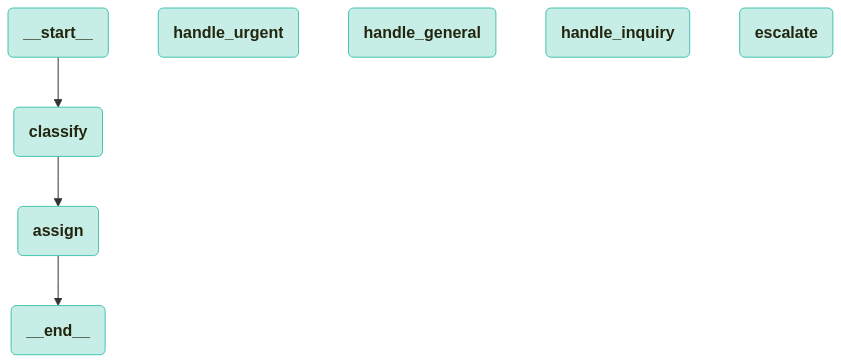

In [8]:
# 정답 코드
# TODO: 그래프를 구성하세요.

# 그래프 빌더 생성
builder = StateGraph(TicketState)

# 노드 추가
builder.add_node("classify", classify_ticket)
builder.add_node("assign", assign_agent)
builder.add_node("handle_urgent", handle_urgent)
builder.add_node("handle_general", handle_general)
builder.add_node("handle_inquiry", handle_inquiry)
builder.add_node("escalate", escalate)

# 엣지 추가
builder.add_edge(START, "classify")
builder.add_edge("classify", "assign")
# assign은 Command를 반환하므로 자동 라우팅
builder.add_edge("handle_urgent", END)
builder.add_edge("handle_general", END)
builder.add_edge("handle_inquiry", END)
builder.add_edge("escalate", END)

# 체크포인터와 함께 컴파일
memory = InMemorySaver()
app = builder.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

### 7. 테스트 및 결과 확인

- 다양한 티켓 시나리오로 시스템을 테스트하세요.

In [ ]:
# 실습 코드
# TODO: VIP 고객의 긴급 티켓을 테스트하세요.
import uuid

print("🎟️ 테스트 1: VIP 고객 긴급 티켓\n")

ticket_id = f"TICKET-{uuid.uuid4().hex[:8]}"
config = # 코드 입력: thread_id 포함

# 티켓 생성
result = # 코드 입력: app.invoke 실행

# 결과 확인
print(f"\n📦 최종 상태: {result['status']}")
print(f"👥 담당자: {result['assigned_to']}")
print(f"📝 해결: {result.get('resolution', '처리 중')}")

# interrupt 시점에서 결정
# app.invoke(Command(resume={"escalate": True}), config)

In [ ]:
# 정답 코드
# TODO: VIP 고객의 긴급 티켓을 테스트하세요.
import uuid

print("🎟️ 테스트 1: VIP 고객 긴급 티켓\n")

ticket_id = f"TICKET-{uuid.uuid4().hex[:8]}"
config = {"configurable": {"thread_id": ticket_id}}

# 티켓 생성
result = app.invoke(
    {
        "messages": [
            HumanMessage(
                content="결제가 실패하고 계정이 잘못 차감되었습니다. 급하게 해결해주세요!"
            )
        ],
        "ticket_id": ticket_id,
        "customer_tier": "VIP",
    },
    config,
)

# 결과 확인
print(f"\n📦 최종 상태: {result['status']}")
print(f"👥 담당자: {result['assigned_to']}")
print(f"📝 해결: {result.get('resolution', '처리 중')}")

# interrupt 시점에서 결정 (필요시)
# app.invoke(Command(resume={"escalate": True}), config)

🎟️ 테스트 1: VIP 고객 긴급 티켓

🎫 티켓 분류: 유형=긴급, 우선순위=high
👥 할당: 시니어 상담원 → handle_urgent
🚨 긴급 티켓 처리 중...
🤚 시니어 상담원의 확인이 필요합니다.

📦 최종 상태: 처리중
👥 담당자: 시니어 상담원
📝 해결: 처리 중


In [ ]:
# 추가 테스트 시나리오

print("\n🎟️ 테스트 2: 일반 문의 티켓\n")

ticket_id2 = f"TICKET-{uuid.uuid4().hex[:8]}"
config2 = {"configurable": {"thread_id": ticket_id2}}

result2 = app.invoke(
    {
        "messages": [
            HumanMessage(content="제품의 가격과 할인 정책에 대해 문의드립니다.")
        ],
        "ticket_id": ticket_id2,
        "customer_tier": "regular",
    },
    config2,
)

print(f"\n📦 최종 상태: {result2['status']}")
print(f"👥 담당자: {result2['assigned_to']}")
print(f"📝 해결: {result2.get('resolution', '처리 중')}")

print("\n🎟️ 테스트 3: Command를 통한 재할당\n")

# 티켓을 다른 팀으로 재할당
ticket_id3 = f"TICKET-{uuid.uuid4().hex[:8]}"
config3 = {"configurable": {"thread_id": ticket_id3}}

# 처음 할당
app.invoke(
    {
        "messages": [HumanMessage(content="기술적인 문제가 발생했습니다.")],
        "ticket_id": ticket_id3,
        "customer_tier": "regular",
    },
    config3,
)

# Command로 재할당
print("🔄 Command로 다른 팀으로 재할당...")
app.update_state(config3, {"assigned_to": "시니어 기술팀", "priority": "high"})

# 상태 확인
state = app.get_state(config3)
print(f"👥 재할당된 담당자: {state.values['assigned_to']}")
print(f"⚡ 변경된 우선순위: {state.values['priority']}")


🎟️ 테스트 2: 일반 문의 티켓

🎫 티켓 분류: 유형=문의, 우선순위=low
👥 할당: 일반 상담원 → handle_inquiry
❓ 문의 티켓 처리 중...

📦 최종 상태: 해결
👥 담당자: 일반 상담원
📝 해결: 요청하신 정보를 제공했습니다. 티켓 #TICKET-e2309efc

🎟️ 테스트 3: Command를 통한 재할당

🎫 티켓 분류: 유형=일반, 우선순위=medium
👥 할당: 기술 지원팀 → handle_general
📧 일반 티켓 처리 중...
🔄 Command로 다른 팀으로 재할당...
👥 재할당된 담당자: 시니어 기술팀
⚡ 변경된 우선순위: high
